In this notebook, we try to predict the flow using a neural network model.

## **Setup**

Mount GGdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Go to the project directory in my GGDrive

In [2]:
cd "/content/drive/MyDrive/Colab Notebooks/Flood Prediction 2"

/content/drive/MyDrive/Colab Notebooks/Flood Prediction 2


Prepare some constants

In [3]:
DATA_PATH = "Data_training"
MODEL_PATH = "model"

## **Get data**

The dataset contain **water flow**, **rainfall** each day from 1978 to 2006

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from os import path # Join path

data = pd.read_csv(path.join(DATA_PATH, "DATA_0409.csv"))
data = data.drop(columns=["TIME", "RF_YN"])

# this field for time in each year
data["TIME"] = data.apply(lambda row: row.name % 365, axis=1) # apply in each row (axis = 1)

data.head(10)

,FLOW,RAINFALL,TIME
0,51.9,0.0,0
1,51.3,126.1,1
2,48.6,46.8,2
3,96.6,19.7,3
4,107.0,64.4,4
5,147.0,36.8,5
6,105.0,0.9,6
7,86.2,2.9,7
8,77.4,13.4,8
9,95.0,65.6,9


Use `matplotlib` to visualize data.

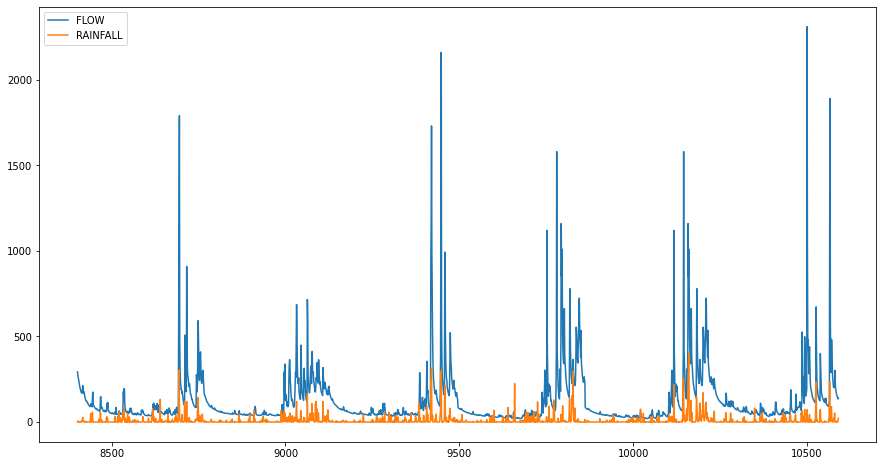

In [11]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
mpl.rcParams['axes.grid'] = False

# plot_cols = ["FLOW", "RAINFALL", "TIME"]
plot_cols = ["FLOW", "RAINFALL"]
plot_features = data[plot_cols][-365 * 6 : -1]
plot_features.plot(subplots = False)

In each frequency, temperature, humidity and rain fall is almost repeat the same year by year.

Next, we check the information about the dataset such as: count null rows, get the dataset's shape, analyze dataset, ...

In [ ]:
data.isnull().sum()

In [ ]:
print(data.shape)

(10592, 3)


In [ ]:
data.describe()

,FLOW,RAINFALL,TIME
count,10592.000000,10592.000000,10592.000000
mean,127.155203,11.213057,181.881703
std,229.049244,31.109910,105.436598
min,11.300000,0.000000,0.000000
25%,39.475000,0.000000,91.000000
50%,59.100000,0.200000,182.000000
75%,123.000000,8.400000,273.000000
max,4440.000000,493.600000,364.000000


In [ ]:
data.cov()

,FLOW,RAINFALL,TIME
FLOW,52463.556404,4420.196255,8033.251294
RAINFALL,4420.196255,967.826517,831.801592
TIME,8033.251294,831.801592,11116.876289


## **Preprocess data**

The input data have **10 day previous information** (include the current day) in one row.

In [ ]:
NUM_ROW = data.shape[0]
DATE_OFFSET_PREVIOUS = 10;

X_Flow_Frame = pd.DataFrame()
data_offset = pd.DataFrame(data[DATE_OFFSET_PREVIOUS : NUM_ROW - DATE_OFFSET_PREVIOUS], columns=data.columns, copy=True).reset_index(drop=True)
X_Flow_Frame["TIME"] = data_offset.get("TIME")
X_Flow_Frame[f"FLOW_CURRENT"] = data_offset.get("FLOW")

for offset in range(1, DATE_OFFSET_PREVIOUS):
  data_offset = pd.DataFrame(data[(DATE_OFFSET_PREVIOUS - offset) : NUM_ROW - (DATE_OFFSET_PREVIOUS + offset)], columns=data.columns, copy=True).reset_index(drop=True)
  X_Flow_Frame[f"FLOW_{offset}DAYPRE"] = data_offset.get("FLOW")

X_Flow_Frame.head(10)

,TIME,FLOW_CURRENT,FLOW_1DAYPRE,FLOW_2DAYPRE,FLOW_3DAYPRE,FLOW_4DAYPRE,FLOW_5DAYPRE,FLOW_6DAYPRE,FLOW_7DAYPRE,FLOW_8DAYPRE,FLOW_9DAYPRE
0,10,161.0,95.0,77.4,86.2,105.0,147.0,107.0,96.6,48.6,51.3
1,11,128.0,161.0,95.0,77.4,86.2,105.0,147.0,107.0,96.6,48.6
2,12,102.0,128.0,161.0,95.0,77.4,86.2,105.0,147.0,107.0,96.6
3,13,89.4,102.0,128.0,161.0,95.0,77.4,86.2,105.0,147.0,107.0
4,14,81.4,89.4,102.0,128.0,161.0,95.0,77.4,86.2,105.0,147.0
5,15,75.8,81.4,89.4,102.0,128.0,161.0,95.0,77.4,86.2,105.0
6,16,71.8,75.8,81.4,89.4,102.0,128.0,161.0,95.0,77.4,86.2
7,17,68.6,71.8,75.8,81.4,89.4,102.0,128.0,161.0,95.0,77.4
8,18,70.2,68.6,71.8,75.8,81.4,89.4,102.0,128.0,161.0,95.0
9,19,67.8,70.2,68.6,71.8,75.8,81.4,89.4,102.0,128.0,161.0


The label data is the **average water flow in 5 next day.**

In [ ]:
data_flow = pd.DataFrame(data).get(["FLOW"])
data_rainfall = pd.DataFrame(data).get(["RAINFALL"])

def avg_5_next_day(x, df):
  if x.name < df.size - 5:
    return np.average(df.values[x.name : x.name + 5])
  return x

data_flow_avg = data_flow.apply(lambda x: avg_5_next_day(x, data_flow), axis=1)
data_rainfall_avg = data_rainfall.apply(lambda x: avg_5_next_day(x, data_rainfall), axis=1)

# Crop result
data_flow_avg = pd.DataFrame(data_flow_avg[DATE_OFFSET_PREVIOUS : NUM_ROW - DATE_OFFSET_PREVIOUS], columns=data_flow.columns).reset_index(drop=True)
data_rainfall_avg = pd.DataFrame(data_rainfall_avg[DATE_OFFSET_PREVIOUS : NUM_ROW - DATE_OFFSET_PREVIOUS], columns=data_rainfall.columns).reset_index(drop=True)

In [ ]:
Y_Flow_Frame = pd.DataFrame()
Y_Flow_Frame["AVG_FLOW_5DAYNEXT"] = data_flow_avg.get("FLOW")
# Y_Frame["AVG_RAINFALL_5DAYNEXT"] = data_rainfall_avg.get("RAINFALL")

In [ ]:
Y_Flow_Frame.head(10)

,AVG_FLOW_5DAYNEXT
0,112.36
1,95.32
2,84.08
3,77.4
4,73.56
5,70.84
6,68.6
7,67
8,65.46
9,63.04


The data after preprocessing is visualize below

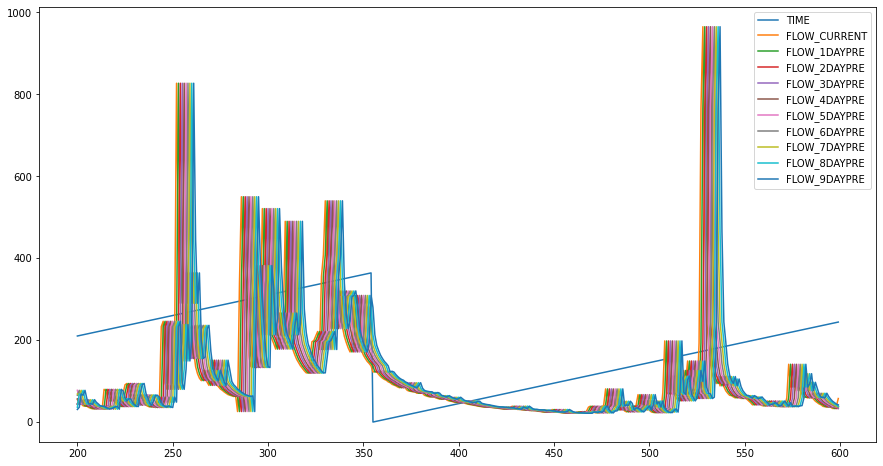

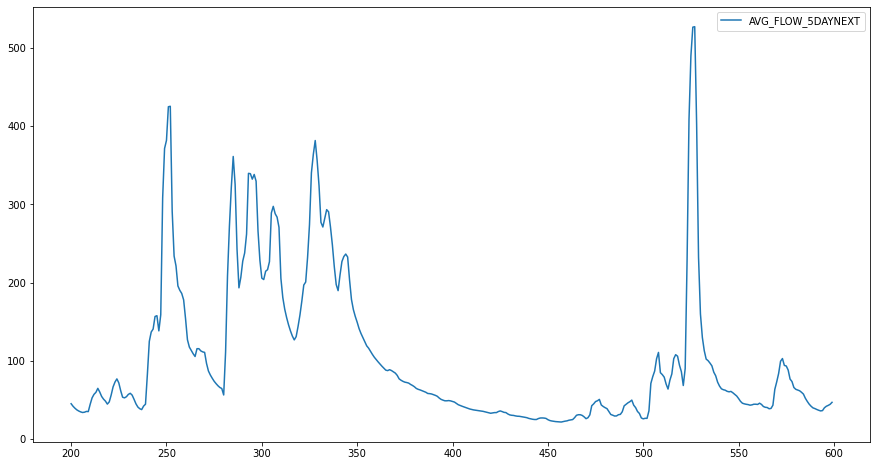

In [ ]:
X_Flow_Frame[200 : 600].plot()
Y_Flow_Frame[200 : 600].plot()

We using `MinMaxScaller` from `sklearn` library to normalize data in range 0 to 100.

In [ ]:
SCALLER_MAX = 100
SCALLER_MIN = 0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaller_X = MinMaxScaler(feature_range=(SCALLER_MIN, SCALLER_MAX))
X = scaller_X.fit_transform(X_Flow_Frame)

scaller_Y = MinMaxScaler(feature_range=(SCALLER_MIN, SCALLER_MAX))
Y = scaller_Y.fit_transform(Y_Flow_Frame)

## **Split data**

We split the data into train and test dataset. The train dataset contain 80% the original data and the test data is the remaining.

In [ ]:
train_length = int(len(X) * 0.8)
val_length = len(X) - train_length

In [ ]:
X_train = X[0 : train_length]
X_val = X[train_length : ]
Y_train = Y[0 : train_length]
Y_val = Y[train_length : ]

In [ ]:
[ X_train_time, X_train_flow ] = np.hsplit(X_train, [1])
[ X_val_time, X_val_flow ] = np.hsplit(X_val, [1])

In [ ]:
[ X_train_flow, X_train_rainfall ] = np.hsplit(X_train, [3])
[ X_val_flow, X_val_rainfall ] = np.hsplit(X_val, [3])
[ Y_train_flow, Y_train_rainfall ] = np.hsplit(Y_train, [1])
[ Y_val_flow, Y_val_rainfall ] = np.hsplit(Y_val, [1])

Save `scaler` to use in the furture.

In [ ]:
SCALER_PATH = "scalers"

In [ ]:
from os import path
from sklearn.externals import joblib

joblib.dump(scaler_X, path.join(SCALER_PATH, "scalerX.save"))
joblib.dump(scaler_Y, path.join(SCALER_PATH, "scalerY.save"))

['scalers/scalerY.save']

In [ ]:
scaler_X_json = {
    "min": scaler_X.feature_range[0],
    "max": scaler_X.feature_range[1],
    "data_min": scaler_X.data_min_.tolist(),
    "data_max": scaler_X.data_max_.tolist()
}

scaler_Y_json = {
    "min": scaler_Y.feature_range[0],
    "max": scaler_Y.feature_range[1],
    "data_min": scaler_Y.data_min_.tolist(),
    "data_max": scaler_Y.data_max_.tolist()
}

In [ ]:
import json

with open(path.join(SCALER_PATH, "scalerX.json"), 'w', encoding='utf-8') as scaler_file:
  json.dump(scaler_X_json, scaler_file, ensure_ascii=False, indent=2)

with open(path.join(SCALER_PATH, "scalerY.json"), 'w', encoding='utf-8') as scaler_file:
  json.dump(scaler_Y_json, scaler_file, ensure_ascii=False, indent=2)

Load `scaler`

In [ ]:
from sklearn.externals import joblib
from os import path

scaler_X = joblib.load(path.join(SCALER_PATH, "scalerX.save"))
scaler_Y = joblib.load(path.join(SCALER_PATH, "scalerY.save"))

## **Build and train the model**

The Rain Fall Model have 2 small model below.

We using normal Fully Connected Layers to build this model.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, InputLayer, LayerNormalization, Reshape, Cropping1D, Conv1D, Flatten

The first model contain a `Sequential` with **three densely connected hidden layers**. The input is the **water flow information in 10 days previous** and the output layer returns **32 nodes containing features of the input**.

In [ ]:
model_flow = Sequential([
    InputLayer(input_shape=(10, ))
])

model_flow.add(Dense(32, activation="relu"))
model_flow.add(BatchNormalization())
model_flow.add(Dense(128, activation="relu"))
model_flow.add(BatchNormalization())
model_flow.add(Dense(32, activation="relu"))

model_flow.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                352       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)                128       
_________________________________________________________________
dense_14 (Dense)             (None, 128)               4224      
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dense_15 (Dense)             (None, 32)                4128      
Total params: 9,344
Trainable params: 9,024
Non-trainable params: 320
_________________________________________________________________


**The second small model** is the date of year (in range 0 - 364).

Because rain fall is **depended on season of the year** so the time is super important. But it **doesn't have the same properties** with rain fall, temperature, humidity. So We put it in that small layer.

In [ ]:
model_time = Sequential(
    InputLayer(input_shape=(1, ))
)

We combine all 3 models above to **one main model**.

This model contain the normal **Fully Connected Layers** to predict the average rain fall in next 5 days.

In [ ]:
from tensorflow.keras.layers import Concatenate

concated_layer = Concatenate()([model_flow.output, model_time.output])
x = (Dense(64, activation="relu"))(concated_layer)
x = (BatchNormalization())(x)
x = (Dense(128, activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dense(512, activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dropout(0.2))(x)
x = (Dense(128, activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dense(64, activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dense(32, activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dense(1, activation="relu"))(x)

In [ ]:
model = Model(inputs=[model_flow.input, model_time.input], outputs=x, name="Concated_layer")

model.summary()

Model: "Concated_layer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 32)           352         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 32)           128         dense_13[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 128)          4224        batch_normalization_10[0][0]     
_____________________________________________________________________________________

Here is the models structure.

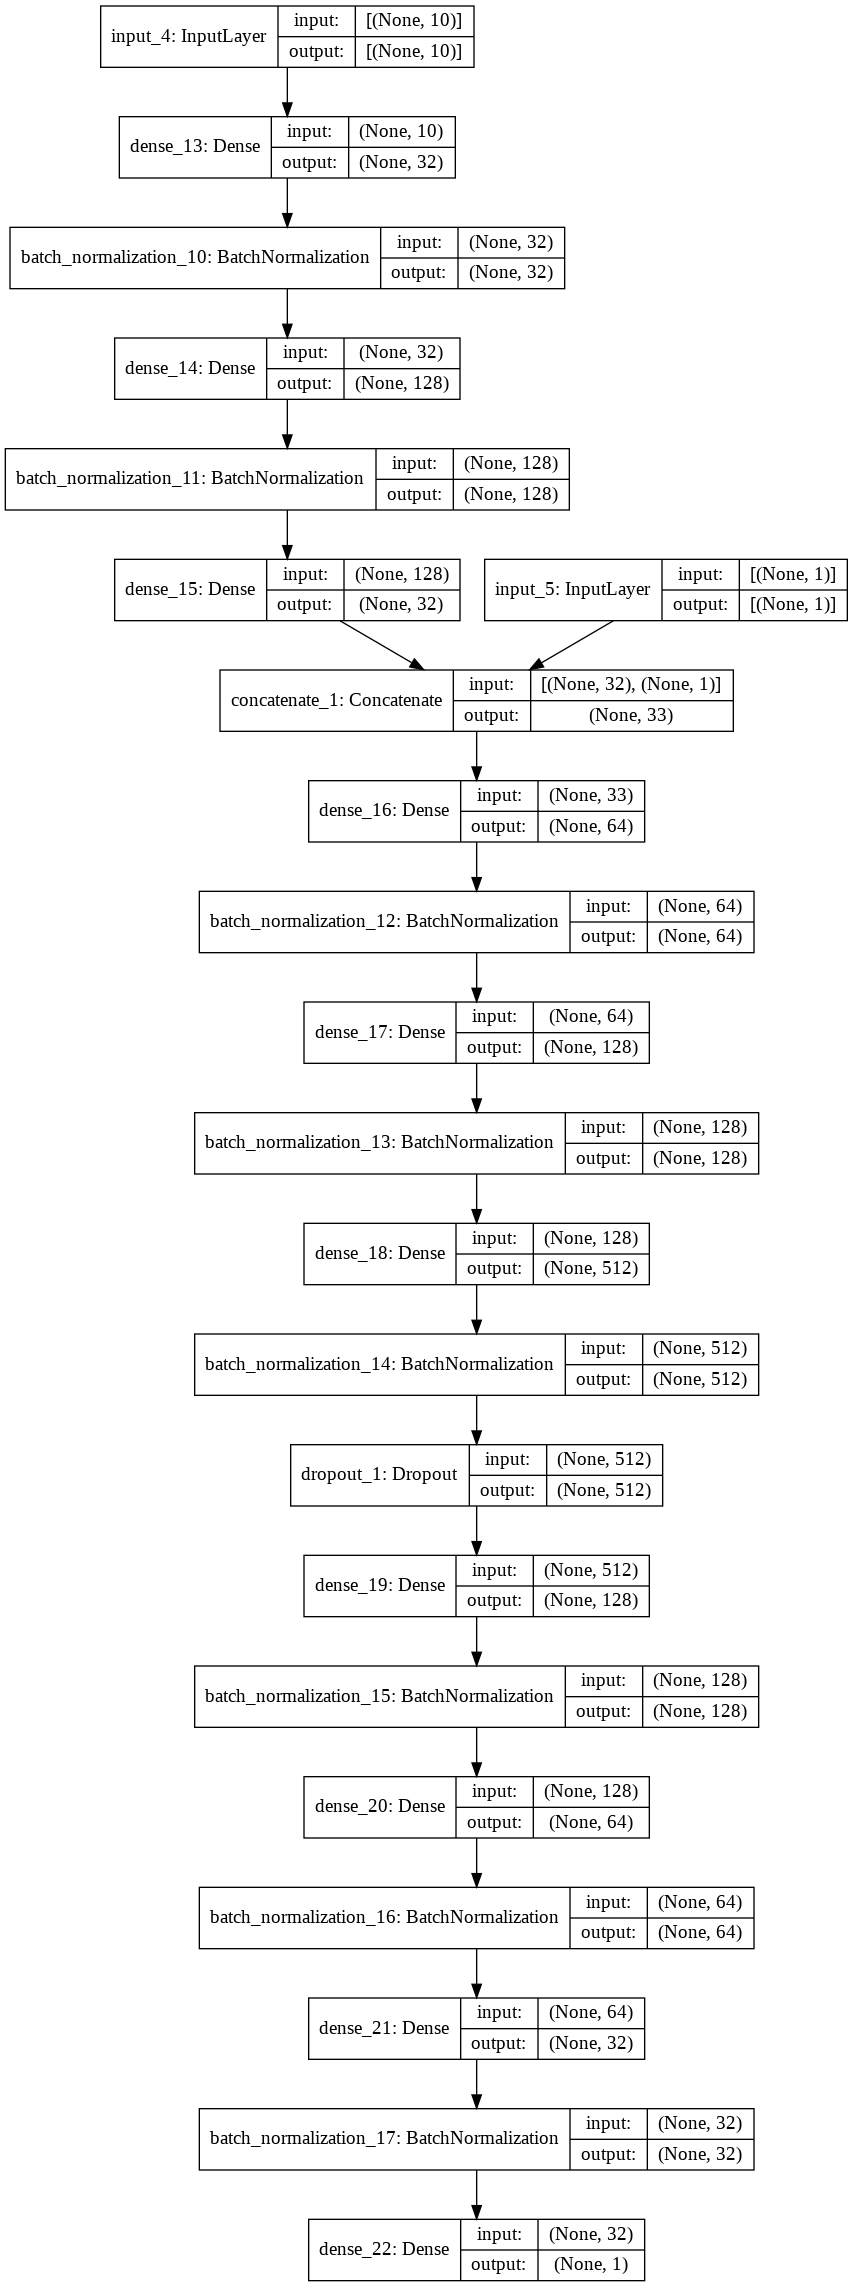

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
print(model.input_shape)
print(model.output_shape)

[(None, 10), (None, 1)]
(None, 1)


We compile the model with the **SGD optimizer function** and using **MSE loss function** to compute the accuracy.

In [ ]:
from tensorflow.keras.optimizers import SGD

optimizer = SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=optimizer, loss="mse", metrics=["mse"])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime

LOG_DIR = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

# **Train model**

In each training circle, we split the data into many batchs. **Each batch contain 64 samples**.

The model is training in **300 epochs**

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
print(model.input_shape)
print(model.output_shape)

[(None, 10), (None, 1)]
(None, 1)


We train save the training result into `history` variable.

In [ ]:
history = model.fit(
    x=[X_train_flow, X_train_time], 
    y=Y_train, 
    validation_data=([X_val_flow, X_val_time], Y_val), 
    batch_size=BATCH_SIZE, 
    callbacks=tensorboard_callback, 
    epochs=EPOCHS, 
    verbose=1
)

Epoch 1/100
133/133 [==============================] - 4s 14ms/step - loss: 27.4518 - mse: 27.4518 - val_loss: 29.0168 - val_mse: 29.0168
Epoch 2/100
133/133 [==============================] - 1s 9ms/step - loss: 23.3499 - mse: 23.3499 - val_loss: 17.9544 - val_mse: 17.9544
Epoch 3/100
133/133 [==============================] - 1s 9ms/step - loss: 22.5183 - mse: 22.5183 - val_loss: 23.4161 - val_mse: 23.4161
Epoch 4/100
133/133 [==============================] - 1s 9ms/step - loss: 22.8797 - mse: 22.8797 - val_loss: 11.4373 - val_mse: 11.4373
Epoch 5/100
133/133 [==============================] - 1s 8ms/step - loss: 22.6719 - mse: 22.6719 - val_loss: 15.0736 - val_mse: 15.0736
Epoch 6/100
133/133 [==============================] - 1s 9ms/step - loss: 22.0315 - mse: 22.0315 - val_loss: 15.6702 - val_mse: 15.6702
Epoch 7/100
133/133 [==============================] - 1s 9ms/step - loss: 22.4862 - mse: 22.4862 - val_loss: 11.4765 - val_mse: 11.4765
Epoch 8/100
133/133 [===================

We visualize the training and the validation step below.

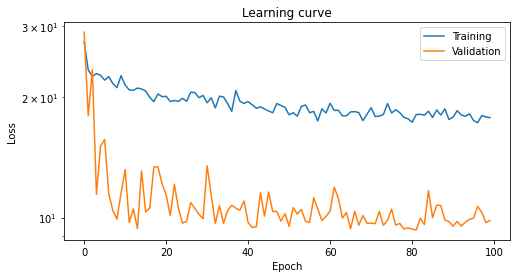

In [ ]:
import matplotlib.pyplot as plt

h = history.model.history

# Plot training & validation loss value
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(h.history['loss'], label='loss')
ax.plot(h.history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')

### **Save model**

Save model into drive

In [ ]:
model.save(filepath=MODEL_PATH)

INFO:tensorflow:Assets written to: model/assets


## **Test Model**

We test the model in the test dataset we have prepare before.

The result is shown below.

**Evaluate on test set**

In [ ]:
loss, mse = model.evaluate(
    x=[X_val_flow, X_val_rainfall, X_val_rf_yn], 
    y=Y_val, verbose=1)
print("Testing set Mean Square Error: {:5.3f} [Water Flow and Rain Fall]".format(mse))

67/67 [==============================] - 0s 2ms/step - loss: 26.3732 - mse: 26.3732
Testing set Mean Square Error: 26.373 [Water Flow and Rain Fall]


Runing test on the test dataset and visualize the result.

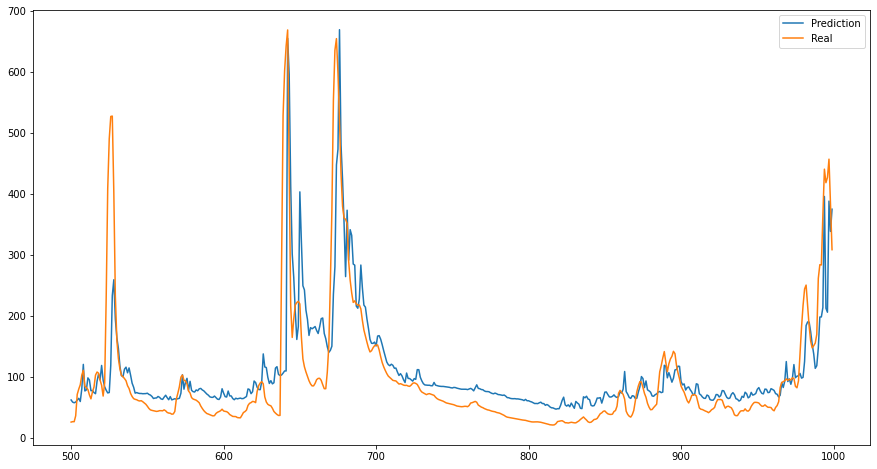

In [ ]:
prediction_flow = model.predict([X_train_flow, X_train_time])

prediction_flow_real = scaller_Y.inverse_transform(prediction_flow)
Y_train_real = scaller_Y.inverse_transform(Y_train)

test_frame = pd.DataFrame()

test_frame["Prediction"] = np.reshape(prediction_flow_real, (len(prediction_flow_real), ))
test_frame["Real"] = np.reshape(Y_train_real, (len(Y_train_real), ))

test_frame[500 : 1000].plot()

## **Convert model to `tensorflow-lite`**

To use this model in edge devices such as android devices. We have to convert the model into `tensorflow lite` format.

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('flood_prediction_model.tflite', 'wb') as f:
  f.write(tflite_model)